### 250bp: EM, HR, IC 

* The following notebook is trained on data generated from revised R script [Oct 12 2017]
    * Exact Match [1] and Homozygous [0] Reference data points
    * Removed all data points with Gtcons and GTconswithoutXX -1
* 5k randomly selected deletions test data was also processed through same R script
* Balanced Training Set for GTcons labels:
* **Train/Prediction Label:** EM, HR, IC

In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [2]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/250bp_EM_HR_IC_HG002_DEL_min1.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/250bp_EM_HR_IC_HG002_DEL_min1.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_insertSizeScore,Ill250.ref_reason_orientation
0,1,HG002,23,72766323,72811839,-45516,Deletion,Deletion,0,0,...,2.0,0.0,985.830076,20.181192,3019.0,416.447168,84.434919,3019.0,NaN,0.0


In [3]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/250bp_HG002_DEL_min1.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/250bp_HG002_DEL_min1.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1,HG002,859,37568322,37568587,-115,Insertion,Deletion,0,0,...,1.0,10.0,1.0,957.875,38.589628,40.0,445.375,91.373871,39.0,1.0


In [4]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Ill250.ref_reason_insertSizeScore', 'Label'}

In [5]:
### Drop columns that are not shared by both dataframes
df_train.drop(['Ill250.ref_reason_insertSizeScore'], axis=1, inplace = True)
df_train.drop(['GTcons'], axis=1, inplace = True)
df_train.drop(['GTconswithoutIll250.GT'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [6]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1,72766323,72811839,-45516,0,0,4,0.076523,110,0.059979,...,89.0,2.0,0.0,985.830076,20.181192,3019.0,416.447168,84.434919,3019.0,0.0


In [7]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [8]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTcons',
 'GTconswithoutIll250.GT',
 'GTsupp',
 'SVtype',
 'id',
 'sample',
 'type'}

In [9]:
### Drop columns that are not shared by both dataframes
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTconswithoutIll250.GT'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [10]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1,72766323,72811839,-45516,0,0,4,0.076523,110,0.059979,...,89.0,2.0,0.0,985.830076,20.181192,3019.0,416.447168,84.434919,3019.0,0.0
1,1,96139975,96142391,-2416,0,0,0,0.000000,2,0.014487,...,7.0,5.0,0.0,991.896552,8.854274,203.0,422.167488,78.005757,203.0,0.0
2,1,109690878,109690918,-39,0,0,0,0.000000,1,0.400000,...,2.0,8.0,0.0,966.620690,38.728421,29.0,454.896552,102.198031,29.0,0.0


In [11]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/2465 with 2 missing, elapsed time: 1.875
Imputing row 101/2465 with 2 missing, elapsed time: 1.926
Imputing row 201/2465 with 2 missing, elapsed time: 1.934
Imputing row 301/2465 with 2 missing, elapsed time: 1.943
Imputing row 401/2465 with 2 missing, elapsed time: 1.952
Imputing row 501/2465 with 2 missing, elapsed time: 1.961
Imputing row 601/2465 with 2 missing, elapsed time: 1.969
Imputing row 701/2465 with 2 missing, elapsed time: 1.978
Imputing row 801/2465 with 2 missing, elapsed time: 1.989
Imputing row 901/2465 with 2 missing, elapsed time: 2.000
Imputing row 1001/2465 with 2 missing, elapsed time: 2.009
Imputing row 1101/2465 with 2 missing, elapsed time: 2.019
Imputing row 1201/2465 with 2 missing, elapsed time: 2.027
Imputing row 1301/2465 with 2 missing, elapsed time: 2.037
Imputing row 1401/2465 with 2 missing, elapsed time: 2.046
Imputing row 1501/2465 with 2 missing, elapsed time: 2.055
Imputing row 1601/2465 with 2 missing, elapsed time: 2.064
Imputing 

In [12]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1.0,72766323.0,72811839.0,-45516.0,0.0,0.0,4.0,0.076523,110.0,0.059979,...,89.0,2.0,0.0,985.830076,20.181192,3019.0,416.447168,84.434919,3019.0,0.0
1,1.0,96139975.0,96142391.0,-2416.0,0.0,0.0,0.0,0.000000,2.0,0.014487,...,7.0,5.0,0.0,991.896552,8.854274,203.0,422.167488,78.005757,203.0,0.0
2,1.0,109690878.0,109690918.0,-39.0,0.0,0.0,0.0,0.000000,1.0,0.400000,...,2.0,8.0,0.0,966.620690,38.728421,29.0,454.896552,102.198031,29.0,0.0


In [13]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['Label']

In [14]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

1.0    775
0.0    962
2.0    728
dtype: int64

In [15]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [16]:
# Remove labels from feature set
X.drop(['Label'],axis=1, inplace = True)

In [17]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.
   **FYI**: [see description below of the SVanalyzer data](#svan_1)
       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
       * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are:
           * Exact Match (1)
           * Homozygous Reference (0)
           * Inaccurate Call (2)
           
   * The trained model will be used to predict labels for 5000 randomly selected deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

<a id='svan_1'></a>
* **Reminder - SVanalyzer data description:** 
     * **1000 Exact Match**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Homozygous Reference**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Inaccurate Calls**: 1000 datapoints were randomly selected from the following
[svanalyzer_union_170509_refalt.2.2.2.clustered.uniquecalls.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
   
   * Source of Features: svviz, GA4GH [tandem repeat, segmental duplications, refN], R analysis [consensus genotype, GTsup]   
    

** Train Random Forest Classifier **

<a id='train_test'></a>

In [18]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)

In [19]:
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



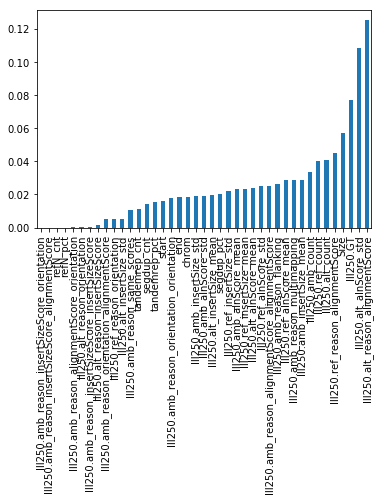

In [20]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.sort()
feature_importances.plot.bar()

In [21]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

1.0    545
0.0    676
2.0    504
dtype: int64

In [22]:
pred = model.predict(X_test)

In [23]:
precision_score(pred, y_test, average='micro') 

0.77567567567567564

In [24]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,Size,chrom,end,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
581,-1.0,973.929825,14.877110,57.0,419.54386,85.982877,57.0,0.0,0.0,887.694737,...,-34.0,6.0,74305662.0,0.0,0.0,0.0,0.0,74305627.0,1.0,1.000000
1366,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,860.469072,...,-63.0,4.0,3387751.0,0.0,0.0,0.0,0.0,3387687.0,0.0,0.000000
195,1.0,982.142857,7.899884,28.0,416.00000,81.548408,28.0,0.0,0.0,878.798995,...,-30.0,14.0,80096183.0,0.0,0.0,0.0,0.0,80096152.0,1.0,1.000000
1380,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,892.471429,...,-201.0,4.0,44018993.0,0.0,0.0,0.0,0.0,44018792.0,1.0,1.000000
878,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,906.129944,...,-23.0,10.0,114858945.0,0.0,0.0,0.0,0.0,114858922.0,1.0,0.130435


In [25]:
labels = pd.DataFrame(y_test)

In [26]:
df_Xtest['predicted_label'] = pred
df_Xtest['Label'] = df_train['Label']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [27]:
pd.value_counts(df_Xtest['Label'].values, sort=False)

0    286
1    230
2    224
dtype: int64

In [28]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

1.0    243
0.0    337
2.0    160
dtype: int64

In [29]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['Label']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[251   8  27]
 [  4 208  18]
 [ 82  27 115]]


In [30]:
df_Xtest['Label'].replace(0, 'Homozygous_Reference', inplace=True)
df_Xtest['Label'].replace(1, 'Exact_Match', inplace=True)
df_Xtest['Label'].replace(2, 'Inaccurate_Call', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Exact_Match', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Inaccurate_Call', inplace=True)

In [31]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Exact_Match,Homozygous_Reference,Inaccurate_Call,All
True,,,,
Exact_Match,208,4,18,230
Homozygous_Reference,8,251,27,286
Inaccurate_Call,27,82,115,224
All,243,337,160,740


In [32]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

                      precision    recall  f1-score   support

         Exact_Match       0.86      0.90      0.88       230
Homozygous_Reference       0.74      0.88      0.81       286
     Inaccurate_Call       0.72      0.51      0.60       224

         avg / total       0.77      0.78      0.77       740



***
Predict
***

Description:

   * In the [previous section](#machine_learning) the model was trained on svanalyzer data.
   **FYI**: [see description below of the SVanalyzer data](#svan_2)
       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
       * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are:
           * Exact Match (1)
           * Homozygous Reference (0)
           * Inaccurate Call (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

<a id='svan_2'></a>
* **Reminder - SVanalyzer data description:** 
     * **1000 Exact Match**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Homozygous Reference**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Inaccurate Calls**: 1000 datapoints were randomly selected from the following
[svanalyzer_union_170509_refalt.2.2.2.clustered.uniquecalls.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
   
   * Source of Features: svviz, GA4GH [tandem repeat, segmental duplications, refN], R analysis [consensus genotype, GTsup]   
   

** Load Data **

In [33]:
X2 = df_test

** Impute missing values using KNN **

In [34]:
#Convert dataframe to matrix
X2=X2.as_matrix()

#Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/3828 with 1 missing, elapsed time: 4.693
Imputing row 101/3828 with 1 missing, elapsed time: 4.699
Imputing row 201/3828 with 1 missing, elapsed time: 4.704
Imputing row 301/3828 with 1 missing, elapsed time: 4.710
Imputing row 401/3828 with 1 missing, elapsed time: 4.716
Imputing row 501/3828 with 1 missing, elapsed time: 4.722
Imputing row 601/3828 with 1 missing, elapsed time: 4.729
Imputing row 701/3828 with 1 missing, elapsed time: 4.735
Imputing row 801/3828 with 1 missing, elapsed time: 4.741
Imputing row 901/3828 with 1 missing, elapsed time: 4.747
Imputing row 1001/3828 with 1 missing, elapsed time: 4.754
Imputing row 1101/3828 with 1 missing, elapsed time: 4.760
Imputing row 1201/3828 with 1 missing, elapsed time: 4.767
Imputing row 1301/3828 with 1 missing, elapsed time: 4.776
Imputing row 1401/3828 with 1 missing, elapsed time: 4.784
Imputing row 1501/3828 with 1 missing, elapsed time: 4.789
Imputing row 1601/3828 with 1 missing, elapsed time: 4.797
Imputing 

In [35]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.000000,3.0,0.818868,...,1.0,10.0,1.0,957.875000,38.589628,40.0,445.375,91.373871,39.0,1.0
1,1.0,112835104.0,112837661.0,-2534.0,0.0,0.0,1.0,0.890888,6.0,0.460305,...,1.0,4.0,0.0,970.000000,15.099669,4.0,365.750,53.932249,4.0,0.0
2,1.0,1092675.0,1092715.0,-40.0,0.0,0.0,0.0,0.000000,1.0,1.000000,...,0.0,5.0,0.0,973.666667,21.522598,6.0,396.500,44.962021,6.0,0.0


In [36]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.000000,3.0,0.818868,...,1.0,10.0,1.0,957.875000,38.589628,40.0,445.375,91.373871,39.0,1.0
1,1.0,112835104.0,112837661.0,-2534.0,0.0,0.0,1.0,0.890888,6.0,0.460305,...,1.0,4.0,0.0,970.000000,15.099669,4.0,365.750,53.932249,4.0,0.0
2,1.0,1092675.0,1092715.0,-40.0,0.0,0.0,0.0,0.000000,1.0,1.000000,...,0.0,5.0,0.0,973.666667,21.522598,6.0,396.500,44.962021,6.0,0.0


In [37]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

<a id='prediction_step'></a>

In [38]:
pred = model.predict(X5)

In [39]:
pred_prob = model.predict_proba(X5)

In [40]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTcons'] = df_test_2['GTcons']
X5['GTsupp'] = df_test_2['GTsupp']
X5['GTconswithoutIll250.GT'] = df_test_2['GTconswithoutIll250.GT']

In [41]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/250bp_pred_prob_DEL_SVanalyzer_revised_EMHRIC.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [42]:
X6 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/250bp_pred_prob_DEL_SVanalyzer_revised_EMHRIC.csv')

In [43]:
X6.rename(columns={'1': 'Homozygous_Reference_SVan_predprob_250bp'}, inplace=True)
X6.rename(columns={'2': 'Exact_Match_predprob_250bp'}, inplace=True)
X6.rename(columns={'3': 'Inaccurate_Call_predprob_250bp'}, inplace=True)
X6.rename(columns={'predicted_label': '250bp_predicted_EMHRIC_label'}, inplace=True)

In [ ]:
X6.head(3)

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/250bp_final_df_DEL_SVanalyzer_revised_EMHRIC.csv', index=False)

***
Label Analysis
***

Description:
  * Comparison of model predicted labels [Exact Match, Homozygous Reference, Inaccurate Calls] to consensus genotype for the 5000 randomly selected datapoints from union_refalt.vcf for HG002 only

In [44]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['250bp_predicted_EMHRIC_label']
print(confusion_matrix(consensus_GT, predict))

[[ 577   15  261]
 [  27 1935  232]
 [   3  727   51]]


In [45]:
from sklearn.metrics import confusion_matrix
GT_without_XX = X6['GTconswithoutIll250.GT']
predict = X6['250bp_predicted_EMHRIC_label']
print(confusion_matrix(consensus_GT, predict))

[[ 577   15  261]
 [  27 1935  232]
 [   3  727   51]]


In [46]:
pd.value_counts(df_test_2['GTconswithoutIll250.GT'].values, sort=False)

0     853
2     781
1    2194
dtype: int64

In [47]:
pd.value_counts(df_test_2['GTcons'].values, sort=False)

0     853
2     781
1    2194
dtype: int64

In [48]:
X6['GTcons'].replace(-1, 'Unknown', inplace=True)
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['250bp_predicted_EMHRIC_label'].replace(0.0, 'Homozygous_Reference_SVan', inplace=True)
X6['250bp_predicted_EMHRIC_label'].replace(1.0, 'Exact_Match', inplace=True)
X6['250bp_predicted_EMHRIC_label'].replace(2.0, 'Inaccurate_Call', inplace=True)

In [49]:
X6['GTconswithoutIll250.GT'].replace(-1, 'Unknown', inplace=True)
X6['GTconswithoutIll250.GT'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTconswithoutIll250.GT'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTconswithoutIll250.GT'].replace(2, 'Homozygous_Variant', inplace=True)

** Compare SVanalyzer Labels to GTcons **

In [50]:
pd.crosstab(consensus_GT, predict, rownames=['GTcons'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons,,,,
Heterozygous_Variant,1935,27,232,2194
Homozygous_Reference,15,577,261,853
Homozygous_Variant,727,3,51,781
All,2677,607,544,3828


** Compare SVanalyzer Labels to LOO Consensus GT **

In [51]:
pd.crosstab(GT_without_XX, predict, rownames=['GTcons_withoutXX'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons_withoutXX,,,,
Heterozygous_Variant,1935,27,232,2194
Homozygous_Reference,15,577,261,853
Homozygous_Variant,727,3,51,781
All,2677,607,544,3828


** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following svanalyzer labels:
    * Homozygous Reference: 0 
    * Exact Match: 1 
    * Inaccurate Call: 2 
* Here **high confidence labels** are the labels predicted by the model that were also assigned a predict probability of either 0.9 or 1
* The following is an analysis of predicted svanalyzer labels with predict probability >0.9

In [52]:
high_conf_labels = X6[(X6['Homozygous_Reference_SVan_predprob_250bp'] == 1) | (X6['Homozygous_Reference_SVan_predprob_250bp'] == 0.9) | (X6['Exact_Match_predprob_250bp'] == 1) | (X6['Exact_Match_predprob_250bp'] == 0.9) | (X6['Inaccurate_Call_predprob_250bp'] == 1) | (X6['Inaccurate_Call_predprob_250bp'] == 0.9)]

** Consensus Genotype versus SVanalyzer Labels **

In [53]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['250bp_predicted_EMHRIC_label']
pd.crosstab(consensus_GT, predict, rownames=['GTcons'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons,,,,
Heterozygous_Variant,1119,0,44,1163
Homozygous_Reference,0,206,36,242
Homozygous_Variant,492,0,3,495
All,1611,206,83,1900


** LOO Genotype versus SVanalyzer Labels **

In [54]:
consensus_GT = high_conf_labels['GTconswithoutIll250.GT']
predict = high_conf_labels['250bp_predicted_EMHRIC_label']
pd.crosstab(consensus_GT, predict, rownames=['GTcons_without_XX'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons_without_XX,,,,
Heterozygous_Variant,1119,0,44,1163
Homozygous_Reference,0,206,36,242
Homozygous_Variant,492,0,3,495
All,1611,206,83,1900


***
Graphs
***

** Exact Match **

In [55]:
em = X5['predicted_label'] == 1.0
exact_match = X5[em]

In [56]:
exact_match.head(1)

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutIll250.GT
1,-1.0,942.288889,19.746867,45.0,498.422222,83.528435,36.0,9.0,0.0,876.777778,...,0.0,1.0,0.890888,112835104,6.0,0.460305,1.0,2,1,2


In [57]:
output_notebook()

Loading BokehJS ...

In [58]:
p = figure()
p = Histogram(exact_match, values='GTcons', title='Exact_Match_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

** Homozygous Reference **

In [59]:
hr = X5['predicted_label'] == 0.0
hom_ref = X5[hr]
hom_ref.head(1)

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutIll250.GT
5,-1.0,978.333333,17.48968,6.0,430.833333,75.987755,6.0,0.0,0.0,875.13369,...,0.0,0.0,0.0,4999647,0.0,0.0,0.0,1,1,1


In [60]:
p = figure()
p = Histogram(hom_ref, values='GTcons', title='Homozygous_Reference_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

** Inaccurate Call **

In [61]:
ic = X5['predicted_label'] == 2.0
inac_call = X5[ic]
inac_call.head(1)

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutIll250.GT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,882.616114,...,0.0,0.0,0.0,37568322,3.0,0.818868,2.0,0,4,0


In [62]:
p = figure()
p = Histogram(inac_call, values='GTcons', title='Inaccurate_Call_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)